Problem 1:
I'll mark each statement as true or false:

1. Direct K-fold cross-validation requires K model re-fits, which may be computationally demanding, especially when inverse inference is costly. **TRUE**

2. Bayes factors (BFs) are relative measures, that is, they cannot differentiate between "equally good" and "equally bad" models. **TRUE**

3. Marginal likelihoods and, by extension, Bayes factors (BFs) cannot be used to compare models with different likelihoods. **FALSE** - Bayes factors can compare models with different likelihoods as they are ratios of marginal likelihoods.

4. Both the Binomial and the Dirichlet distribution can be formulated as special cases of the Multinomial distribution. **FALSE** - While the Binomial is a special case of the Multinomial, the Dirichlet is not. The Dirichlet is a distribution over probability vectors, while the Multinomial is a distribution over counts.

5. Bayesian leave-one-out cross-validation (LOO-CV) relies on the posterior predictive distribution of left-out data points. **TRUE**

6. The Akaike Information Criterion (AIC) penalizes model complexity indirectly through the variance of a model's marginal likelihood. **FALSE** - AIC penalizes model complexity directly through the number of parameters, not through variance of the marginal likelihood.

7. The log-predictive density (LPD) is a relative metric of model complexity. **FALSE** - LPD is a measure of predictive accuracy, not complexity.

8. The LPD can be approximated by evaluating the likelihood of each posterior draw (e.g., as provided by an MCMC sampler) and taking the average of all resulting likelihood values. **TRUE**

9. Bayes factors do not depend on the prior odds, that is, the ratio of prior model probabilities p(M1)/p(M2). **TRUE**

10. we should always prefer information criteria to cross-validation in terms of estimation predictive performance. **FALSE** - This blanket statement is incorrect. The best method depends on the specific context, with cross-validation often being more accurate but computationally expensive.

Problem 3:

Problem 4:

Model coefficients (feature importance):
    Feature  Coefficient
1       Age     0.252399
0       BMI     0.163485
2  Children     0.055857
Intercept: 0.0000
RMSE between predictive means and actual test values (standardized): 0.9542
RMSE between predictive means and actual test values (original scale): 11463.6925
95% confidence interval for RMSE (original scale): [15027.37, 17449.48]


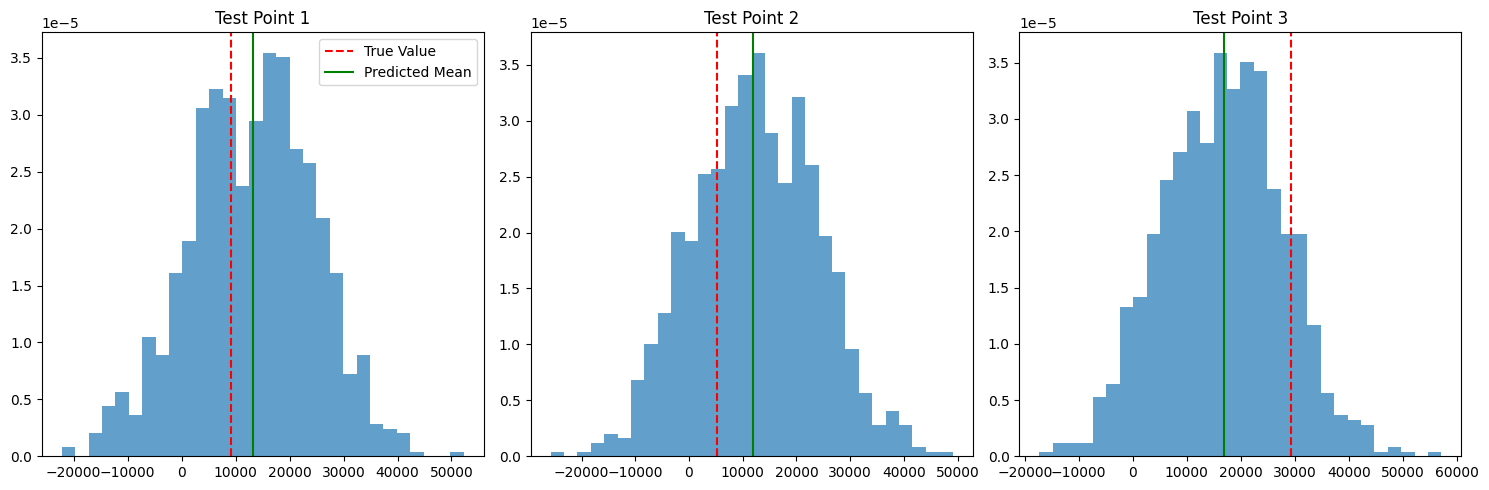

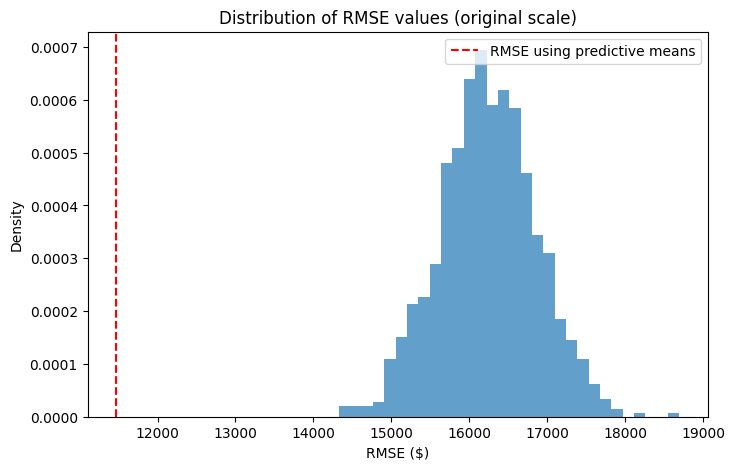

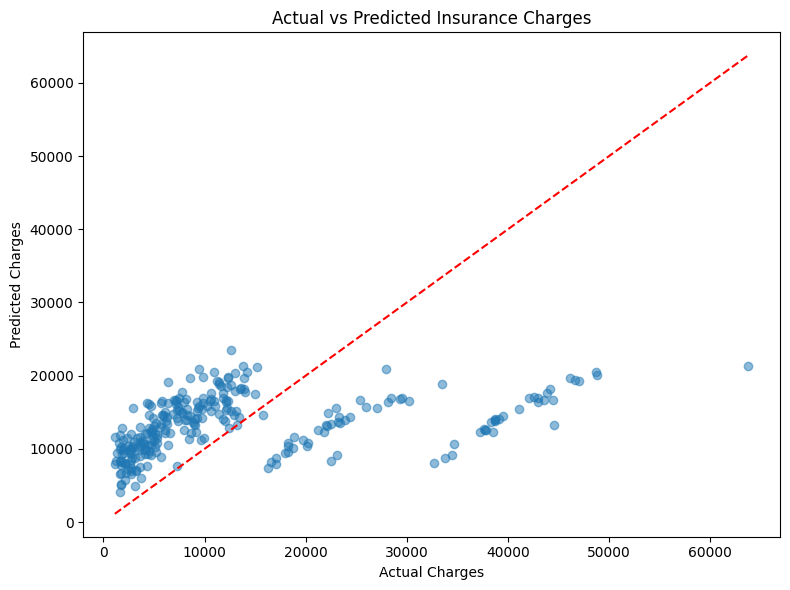

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Load the insurance data
data = pd.read_csv('./insurance.csv')

# Split the data into training and testing
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_size = len(train_data)
test_size = len(test_data)

# Standardize features and target
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Process training data
X_train = scaler_X.fit_transform(train_data[['bmi', 'age', 'children']].values)
y_train = scaler_y.fit_transform(train_data[['charges']].values).flatten()

# Process test data (using training scalers)
X_test = scaler_X.transform(test_data[['bmi', 'age', 'children']].values)
y_test = scaler_y.transform(test_data[['charges']].values).flatten()

# Fit Bayesian Ridge Regression
brr = BayesianRidge(compute_score=True)
brr.fit(X_train, y_train)

# Get feature importance (standardized coefficients)
feature_names = ['BMI', 'Age', 'Children']
coefficients = pd.DataFrame(
    {'Feature': feature_names, 'Coefficient': brr.coef_}
).sort_values('Coefficient', ascending=False)

print("Model coefficients (feature importance):")
print(coefficients)
print(f"Intercept: {brr.intercept_:.4f}")

# Get predictive means
y_pred_mean = brr.predict(X_test)

# For Bayesian Ridge, get prediction standard deviation
y_pred_std = np.sqrt(1.0/brr.alpha_ + np.sum(X_test * np.dot(brr.sigma_, X_test.T).T, axis=1))

# Sample from the predictive distribution
n_samples = 1000
pred_samples = np.zeros((X_test.shape[0], n_samples))
for i in range(X_test.shape[0]):
    pred_samples[i, :] = np.random.normal(y_pred_mean[i], y_pred_std[i], n_samples)

# Calculate RMSE between predictive means and actual test values (in standardized scale)
rmse_standardized = np.sqrt(mean_squared_error(y_test, y_pred_mean))

# Calculate RMSE in original scale
y_pred_mean_original = scaler_y.inverse_transform(y_pred_mean.reshape(-1, 1)).flatten()
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred_mean_original))

print(f"RMSE between predictive means and actual test values (standardized): {rmse_standardized:.4f}")
print(f"RMSE between predictive means and actual test values (original scale): {rmse_original:.4f}")

# Visualize the predictive distribution for a few test points
plt.figure(figsize=(15, 5))
for i in range(3):  # Show first 3 test points
    plt.subplot(1, 3, i+1)
    # Convert samples back to original scale
    samples_original = scaler_y.inverse_transform(
        pred_samples[i, :].reshape(-1, 1)).flatten()
    true_original = scaler_y.inverse_transform([[y_test[i]]])[0][0]
    pred_original = scaler_y.inverse_transform([[y_pred_mean[i]]])[0][0]
    
    plt.hist(samples_original, bins=30, alpha=0.7, density=True)
    plt.axvline(true_original, color='r', linestyle='--', label='True Value')
    plt.axvline(pred_original, color='g', linestyle='-', label='Predicted Mean')
    plt.title(f'Test Point {i+1}')
    if i == 0:
        plt.legend()
plt.tight_layout()

# Propagating uncertainty to RMSE values
# For each sample, compute an RMSE
rmse_samples = np.zeros(n_samples)
for s in range(n_samples):
    sample_preds = pred_samples[:, s]
    rmse_samples[s] = np.sqrt(mean_squared_error(y_test, sample_preds))

# Convert RMSE samples to original scale (approximately)
std_y = np.std(data['charges'])
rmse_samples_original = rmse_samples * std_y

# Plot the distribution of RMSE values
plt.figure(figsize=(8, 5))
plt.hist(rmse_samples_original, bins=30, alpha=0.7, density=True)
plt.axvline(rmse_original, color='r', linestyle='--', label='RMSE using predictive means')
plt.title('Distribution of RMSE values (original scale)')
plt.xlabel('RMSE ($)')
plt.ylabel('Density')
plt.legend()

# Calculate 95% confidence interval for RMSE
rmse_lower = np.percentile(rmse_samples_original, 2.5)
rmse_upper = np.percentile(rmse_samples_original, 97.5)
print(f"95% confidence interval for RMSE (original scale): [{rmse_lower:.2f}, {rmse_upper:.2f}]")

# Plot actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test_original, y_pred_mean_original, alpha=0.5)
plt.plot([min(y_test_original), max(y_test_original)], 
         [min(y_test_original), max(y_test_original)], 'r--')
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title('Actual vs Predicted Insurance Charges')
plt.tight_layout()

## How good are our predictions?

Our model did okay, but with a lot of uncertainty. Looking at just the average predictions, we got an RMSE of $11,463.69, which means we're typically off by about $11.5K when predicting someone's insurance charges. That's pretty significant considering the average insurance charge in the dataset.

When we account for all the uncertainty in our model, things look even shakier. Our 95% confidence interval for RMSE is [$15,027.37, $17,449.48]. Notice how this entire range is higher than our point estimate! This tells us that using just the average predictions actually paints an overly optimistic picture. In reality, our predictions could be off by as much as $17.5K.

This shows we have moderate prediction quality with substantial uncertainty. Insurance charges are complex and likely influenced by factors beyond just age, BMI, and number of children.

## What information did we lose by computing the predictive means?

By just using the average predictions, we threw away all the uncertainty information. It's like saying the weather will be 70°F tomorrow without mentioning it could range from 50°F to 90°F.

For each person in our test set, our model actually gives us a whole range of possible insurance charges, not just one number. When we only look at the average, we can't see how confident (or not) our model is about each prediction. Some predictions might be very uncertain, with a wide range of possible values, while others might be more precise.

This matters in real life. If we're an insurance company using this model, we need to know not just the expected charge but also how much that charge might vary.

## How could we propagate the uncertainty information?

We handled this by sampling many possible predictions for each person and then calculating many possible RMSE values. It's like running thousands of simulations of our prediction model.

For each simulation, we:
1. Generated one possible set of predictions for all people in our test set
2. Calculated how wrong these predictions were (the RMSE)
3. Collected all these RMSE values to see their distribution

This gave us a much more honest assessment of our model's performance, showing that when we account for all sources of uncertainty, our predictions are likely even less accurate than the simple average suggests.

This approach helps us make better decisions by acknowledging the limits of our model rather than being overconfident in its predictions.